### Import Base Model with new top model and frozen layers

In [3]:
import ResNet50finetune
#import VGG16finetune
import h5py

In [4]:
final_model_orig = ResNet50finetune.ResNet50finetune()
final_model_fine = ResNet50finetune.ResNet50finetune()

K.image_dim_ordering: tf
K.image_dim_ordering: tf


In [5]:
weights_path = 'Caffe models/ResNet50/weights/ResNet50-finetune5-14-0.66.h5'
f = h5py.File(weights_path)

In [27]:
k = 171
name = f.attrs['layer_names'][k]
print name
weights = [f[name][h][()] for h in f[name].keys()]
final_model_fine.layers[k].set_weights(weights)


bn5c_branch2c


In [28]:
final_model_fine.layers[k].get_weights()

[array([-1.45125782, -1.65197432, -1.63190234, ..., -1.60618222,
        -1.72180915, -1.93755329], dtype=float32),
 array([ 1.3451786 ,  1.39657283,  1.4453218 , ...,  1.20929563,
         1.59697223,  1.43210948], dtype=float32),
 array([-0.12825978, -0.0863668 , -0.07194976, ..., -0.05564213,
        -0.03709351, -0.0422993 ], dtype=float32),
 array([ 0.0099396 ,  0.00943395,  0.01045332, ...,  0.00850692,
         0.01214169,  0.00997391], dtype=float32)]

In [29]:
final_model_orig.layers[k].get_weights()

[array([ 1.3451786 ,  1.39657283,  1.4453218 , ...,  1.20929563,
         1.59697223,  1.43210948], dtype=float32),
 array([-1.45125782, -1.65197432, -1.63190234, ..., -1.60618222,
        -1.72180915, -1.93755329], dtype=float32),
 array([-0.12825978, -0.0863668 , -0.07194976, ..., -0.05564213,
        -0.03709351, -0.0422993 ], dtype=float32),
 array([ 0.0099396 ,  0.00943395,  0.01045332, ...,  0.00850692,
         0.01214169,  0.00997391], dtype=float32)]

In [7]:
for k in range(len(f.attrs['layer_names'])): 
    name = f.attrs['layer_names'][k]
    weights = [f[name][h][()] for h in f[name].keys()]
    print k
    final_model.layers[k].set_weights(weights)
f.close()
print('Model loaded.')

175
176
177
178
Model loaded.


### Make object from Model to be Finetuned

In [2]:
#final_model = ResNet50finetune.ResNet50finetune()
final_model = VGG16finetune.VGG16finetune()

In [3]:
final_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (None, 224, 224, 64)  1792        input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (None, 224, 224, 64)  36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, 112, 112, 64)  0           block1_conv2[0][0]               
___________________________________________________________________________________________

In [30]:
#from keras.models import Sequential, Model
#from keras.layers import normalization,Input
#import numpy as np

In [53]:
#model1 = Sequential()
#norm_m1 = normalization.BatchNormalization(mode=0, input_shape=(10,), momentum=0.8)
#model1.add(norm_m1)

#a = Input(shape=(10,))
#x = normalization.BatchNormalization(mode=0, momentum=0.8)(a)
#model1 = Model(input=a, output=x)


#for layer in model1.layers:
#    layer.trainable = False
#    if "BatchNormalization" in str(layer):
#        layer.mode = 1
#model1.compile(loss='mse', optimizer='sgd')


#print model1.layers[-1].get_weights()


[array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.], dtype=float32), array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32), array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32), array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.], dtype=float32)]


In [54]:
#X = np.random.normal(loc=5.0, scale=10.0, size=(1000, 10))
#history = model1.fit(X, X, nb_epoch=4, verbose=0)

In [55]:
#print model1.layers[-1].get_weights()


[array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.], dtype=float32), array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32), array([ 4.39246035,  5.12613201,  5.74278688,  3.79823756,  5.09264946,
        5.59720373,  4.07088757,  4.18263102,  4.67154026,  4.94525576], dtype=float32), array([  92.58489227,  106.38678741,   84.66645813,   85.87356567,
         91.14066315,  108.94872284,   96.00917816,   91.13054657,
        104.22420502,  108.7076416 ], dtype=float32)]


In [3]:
from keras import optimizers

In [4]:
final_model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(),
              metrics=['accuracy'])

### Directory to Training and Val images 
Used for ImageDataGenerator

In [5]:
train_data_dir = 'kaggle/Training'
validation_data_dir = 'kaggle/Validation'
nb_train_samples = 1032
nb_validation_samples = 688
nb_epoch = 45

img_height = 224
img_width = 224

In [6]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint


In [10]:
# prepare data augmentation configuration
# Rescale Images
# Sample wise mean center
# Flip images
train_datagen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True,
        samplewise_center = True)

test_datagen = ImageDataGenerator(rescale=1./255, samplewise_center = True)


train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_height, img_width),
        batch_size=32)

validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_height, img_width),
        batch_size=32)

# File to save weights every 5 epochs
file_path = 'Caffe models/ResNet50/weights/ResNet50-finetune5-{epoch:02d}-{val_acc:.2f}.h5'
checkpoint = ModelCheckpoint(file_path, verbose=1, save_weights_only=True, period=5)
callbacks_list = [checkpoint]

# fine-tune the model
history = final_model.fit_generator(
        train_generator,
        samples_per_epoch=nb_train_samples,
        nb_epoch=nb_epoch,
        validation_data=validation_generator,
        nb_val_samples=nb_validation_samples,
        callbacks=callbacks_list)

Found 1032 images belonging to 344 classes.
Found 688 images belonging to 344 classes.
Epoch 1/60


KeyboardInterrupt: 

### Plot the History of Training

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
result = history.history

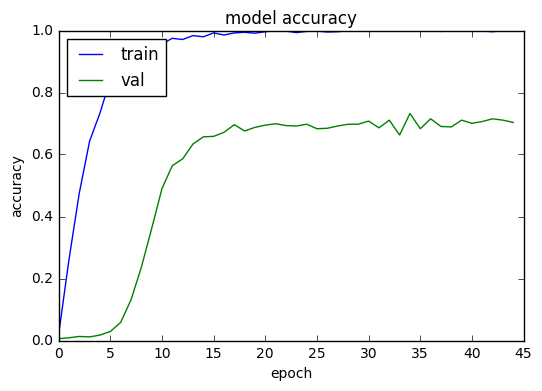

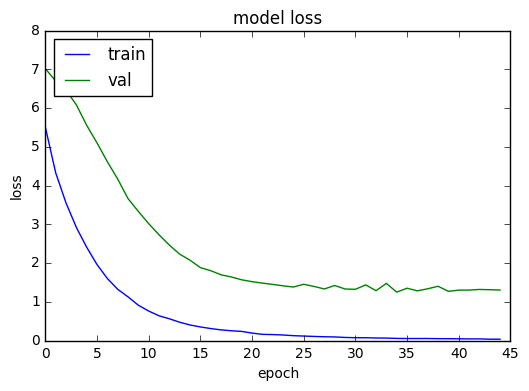

In [10]:
# summarize history for accuracy
plt.plot(result['acc'])
plt.plot(result['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(result['loss'])
plt.plot(result['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()